# Classification of COVID-19 patients
In this guided project we will implement a deep neural network for the classification or diagnosis of patients with suspected infection by the COVID-19 virus from medical imaging data.


## Modify execution environment and choose GPU as support
Before we start writing the code, let's modify the Google Colab runtime to work with GPU hardware. To do this, we go to the 'Runtime environment' menu and select the 'Change runtime environment type' option and in the panel that will open next we choose GPU from the 'Hardware acceleration' drop-down.

# A) Dataset import

We upload the medical images after downloading from [this link](https://drive.google.com/file/d/1zhbccMmGao2mdjZbFlOsOPzxk-6gtwXL/view?usp=sharing) in the supplied .zip file. We will use the panel on the left to have them in the virtual machine that will run this notebook.

The Data folder contains over two thousand 2D chest x-ray images in jpg format.




Options to load the data:


1. If you have a Google Drive account mount the drive and load the Data folder from there



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# The base directory with the Data folder in Google Drive
base_dir = '/content/drive/MyDrive/Documentos/Master IA/Datasets/Datos'

Mounted at /content/drive


2. Upload the .zip file and unzip it


In [ ]:
!unzip "/content/Datos.zip" -d "/content/Datos/"
base_dir = '/content/datos

Archive:  /content/Datos.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of /content/Datos.zip or
        /content/Datos.zip.zip, and cannot find /content/Datos.zip.ZIP, period.


# B) We import the necessary libraries
We load the Sequential libraries for the configuration of the network formed by convolution layers and 2D max pooling, droptout layers and flatten and dense layers.

In [ ]:
from tensorflow.keras.models import Sequential # Model/class on which we build the network layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

# Conv2D -> for edge detection and definition (sharpening) of the image
# Pooling -> reduces the size of the data, the dimensionality of the image
# Dropout -> controls model overfitting
# Flatten -> transforms the feature matrix into a 1D vector
# Dense -> connects the feature vector to the data vector of inputs, predictions of the labels
from tensorflow.keras.optimizers import Adam
# We will use Adam as optimizer
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# It allows us to perform data augmentation tasks
import numpy as np
import matplotlib.pyplot as plt

print("\n - A) Importamos las librerías necesarioas\n") 

Cloning into 'datasets'...
remote: Enumerating objects: 2301, done.
remote: Total 2301 (delta 0), reused 0 (delta 0), pack-reused 2301
Receiving objects: 100% (2301/2301), 1.31 GiB | 29.82 MiB/s, done.
Checking out files: 100% (2295/2295), done.


In [ ]:
# We define the paths to the folders with the training and validation images
import os
import os.path as op

# Base directory with the train and test folders containing the images
# that we will use for model training and validation
base_dir = '/content/datasets/Data'
train_dir = op.join(base_dir, 'train')
test_dir = op.join(base_dir, 'test')

# Within each set we have two directories with chest x-rays
# for each group: COVID or Normal
train_covid_dir = op.join(train_dir, 'COVID19')
train_normal_dir = op.join(train_dir, 'NORMAL')
test_covid_dir = op.join(test_dir, 'COVID19')
test_normal_dir = op.join(test_dir, 'NORMAL')

In [ ]:
# We take a look at the images
# Training set
train_covid_names = sorted(os.listdir(train_covid_dir))
print("\n - First 10 training images (COVID):", train_covid_names[0:10])
train_normal_names = sorted(os.listdir(train_normal_dir))
print("\n - First 10 training images (NORMAL):", train_normal_names[0:10])
# Conjunto de evaluación
test_covid_names = sorted(os.listdir(test_covid_dir))
print("\n - First 10 evaluation images (COVID):", test_covid_names[0:10])
test_normal_names = sorted(os.listdir(test_normal_dir))
print("\n - First 10 evaluation images (NORMAL):", test_normal_names[0:10])

In [ ]:
# How many images we have in our data sets
print(" => Images in the training set:", len(train_covid_names+train_normal_names))
print(" => Images in the evaluation set:", len(test_covid_names+test_normal_names))

# C) Visualization of the images

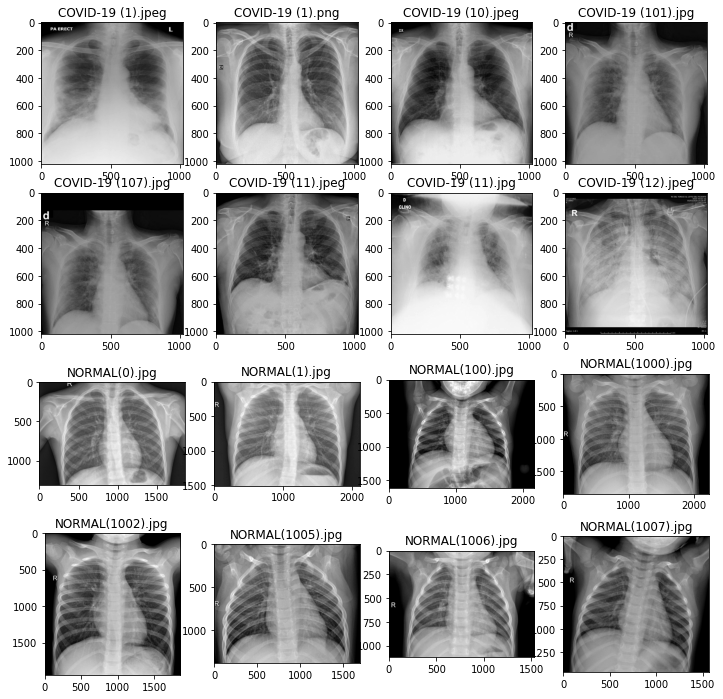

In [ ]:
# Let's visualize some images of the data set in a 4x4 grid
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg

fig = plt.figure(1, figsize=(12, 12))
gs = gridspec.GridSpec(4, 4, figure=fig)
covid_pics = [op.join(train_covid_dir, filename) for filename in train_covid_names[0:8]]
normal_pics = [op.join(train_normal_dir, filename) for filename in train_normal_names[0:8]]
merger_pics = covid_pics + normal_pics
for i, pic_path in enumerate(merger_pics):
  pic_name = op.basename(merger_pics[i])
  ax = fig.add_subplot(gs[i])
  pic_data = mpimg.imread(pic_path)
  ax.imshow(pic_data, cmap='gray')
  ax.set_title(pic_name)
plt.show()


# D) Pre-processing and Data Augmentation

In [ ]:
# We generate the training, evaluation and validation batches
dgen_train = ImageDataGenerator(rescale=1./255,
                                validation_split=0.2,
                                zoom_range = 0.2,
                                horizontal_flip = True)
dgen_test = ImageDataGenerator(rescale=1./255)
dgen_val = ImageDataGenerator(rescale=1./255)
# On each group we apply a renormalization so that the data is
# in the range 0-1 (maximum intensity value is 255)
# On the training set we apply data augmentation methods
# zoom_range -> maximum zoom percentage on the image
# horizontal_flip -> apply horizontal flip 

# Create batch generators containing 80% of the images in the
# training group and the remaining 20% ​​in the validation group
train_generator = dgen_train.flow_from_directory(train_dir,
                                           target_size=(150, 150),
                                           subset = 'training',
                                           batch_size = 32,
                                           class_mode = 'binary')
# Target size -> resize images to fit a size of 150x150 pixels
# Mode -> specifies that this data will be used in the training phase
# batch_size -> number of images to load into memory at each step of the learning process
# class_mode -> binary for dichotomous classification (COVID / Normal), categorical to identify labels

val_generator = dgen_train.flow_from_directory(train_dir,
                                           target_size=(150, 150),
                                           subset = 'validation',
                                           batch_size = 32,
                                           class_mode = 'binary')

test_generator = dgen_train.flow_from_directory(test_dir,
                                           target_size=(150, 150),
                                           batch_size = 32,
                                           class_mode = 'binary')


Found 1449 images belonging to 2 classes.
Found 362 images belonging to 2 classes.
Found 484 images belonging to 2 classes.


In [ ]:
# As we know the two classes of our problem are COVID and Normal, let's see it:
train_generator.class_indices

{'COVID19': 0, 'NORMAL': 1}

In [ ]:
# Let's also see what the sample size is for training the model
train_generator.image_shape
# The size of the images is 150x150 and the dimension value three tells us that the images
# are in RGB format, where the color of each pixel is a combination of red+green+blue

(150, 150, 3)

# E) Construction of the Convolutional Neural Network

In [ ]:
# At this point we can define our convolutional RN model that will learn
# of the grouped data that we have previously worked on
# We will build the model by adding layers to an instance of the Sequential class

model = Sequential()

# The first layer we will use to extract features from the image is
# a convolution layer that applies filters made up of little squares that
# map the input image. We will select 32 features to extract
model.add(Conv2D(filters=32, kernel_size=(5,5), padding='SAME', activation='relu', input_shape=(150, 150, 3))) 
# Add the Pooling layer
model.add(MaxPooling2D(pool_size=(2, 2)))
# Dropout layer 
model.add(Dropout(0.5))

# Let's add a second convolution layer
model.add(Conv2D(filters=64, kernel_size=(5,5), padding='SAME', activation='relu'))
# And the successive Pooling and Dropout layers 
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

# Now we can add the Flatten layer
model.add(Flatten())

# The densely connected layer in which we specify the nodes and the
# activation type
model.add(Dense(256, activation='relu'))

# Added a new Dropout operation that halves the number of nodes
model.add(Dropout(0.5))

# And finally we connect the nodes to create the output with a single node
# Since we are dealing with a classification problem we will use the activation function
# sigmoid
model.add(Dense(1, activation='sigmoid')) 

# Model Summary
print("Resumen del modelo:\n", model.summary())
# In this summary we see that the size of the first tensor has the value None because
# refers to the dimensionality of the batch size, which can take any value
# which best model produces

# After the application of the convolution layer we have a tensor of dimension equal to
# half the input image and with 32 features on the z-axis

# F) Compile and Train the Model

In [ ]:
# To compile our RNC model we will have to:
# 1) Define the optimization method (Adam)
# 2) The value for the learning_rate
# 3) The loss function: bynary cross entropy is a good choice for a binary classification task
# 4) The evaluation metric: we will use accuracy
model.compile(Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
# Compiled the model we can launch the training process
history = model.fit(train_generator,
                    epochs=30,
                    validation_data=val_generator)
# The history object records progress during training, collects the value of the stall function
# and the evaluation metric at each step of the process 

Epoch 1/30
46/46 [==============================] - 58s 1s/step - loss: 0.1811 - accuracy: 0.9393 - val_loss: 0.3181 - val_accuracy: 0.9116
Epoch 2/30
46/46 [==============================] - 57s 1s/step - loss: 0.1351 - accuracy: 0.9538 - val_loss: 0.1018 - val_accuracy: 0.9724
Epoch 3/30
46/46 [==============================] - 58s 1s/step - loss: 0.1278 - accuracy: 0.9600 - val_loss: 0.1121 - val_accuracy: 0.9696
Epoch 4/30
46/46 [==============================] - 59s 1s/step - loss: 0.1232 - accuracy: 0.9572 - val_loss: 0.1196 - val_accuracy: 0.9669
Epoch 5/30
46/46 [==============================] - 58s 1s/step - loss: 0.1657 - accuracy: 0.9393 - val_loss: 0.3040 - val_accuracy: 0.9448
Epoch 6/30
46/46 [==============================] - 58s 1s/step - loss: 0.1495 - accuracy: 0.9538 - val_loss: 0.0995 - val_accuracy: 0.9641
Epoch 7/30
46/46 [==============================] - 58s 1s/step - loss: 0.1106 - accuracy: 0.9683 - val_loss: 0.1665 - val_accuracy: 0.9392
Epoch 8/30
46/46 [==

# G) Performance evaluation

In [ ]:
# Let's see that the values ​​of loss and accuracy have been stored in history
history.history.keys()

In [ ]:
# To evaluate the performance of the model, we represent the values ​​of the metrics of interest as a function of the
# time of training
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss (training)', 'loss (validation'])
plt.title("Evolution of the value of the loss function")
plt.xlabel('epoch')

In [ ]:
# A look at the evolution of precision
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Precision (entrenamiento)', 'Precision (validación)'])
plt.title("Evolution of the precision value")
plt.xlabel('epoch')

In [ ]:
# Finally, we validate the model on the evaluation sample
test_loss, test_accuracy = model.evaluate(test_generator)
# We simply have to evaluate the model we just trained on the data set we had
# reserved for evaluation 
print("\n=> Results on the set of tests:")
print(" - Loss: {:.2f}, Accuracy: {:.2f} ".format(test_loss, test_accuracy))


# H) Results (predictions) on unseen data

In [ ]:
# In this last action we will evaluate our model on the entire set of chest X-ray images
# to get a result (prediction) for the patient: COVID infection or healthy
from google.colab import files
from keras.preprocessing import image
from PIL import Image

uploads = files.upload()
for filename in uploads.keys():
  img_path = '/content/' + filename
  img = image.load_img(img_path, target_size=(150, 150))
  data = image.img_to_array(img)
  data = np.expand_dims(data, axis=0)
  prediction = model.predict(data)
  print("\nX-ray image:", filename)

  if prediction == 0:
    print(" => Detected COVID-19")
  else:
    print(" => Normal state")


